<a href="https://colab.research.google.com/github/vitorlacerda2/contagem-de-plantas/blob/main/ctg_de_plantas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Operações morfológicas, como erosão e dilatação, são técnicas importantes no processamento de imagens para a detecção e contagem de objetos, como plantas em imagens de drones. O processo começa com o pré-processamento da imagem para reduzir ruídos e segmentar as regiões de interesse. Em seguida, a binarização converte a imagem em preto e branco, destacando as plantas. A erosão remove detalhes e ruídos, enquanto a dilatação amplia os objetos e preenche buracos. Após aplicar as operações morfológicas, algoritmos de rotulagem de componentes conectados ou de contagem de objetos podem ser usados para identificar e contar as plantas. A escolha dos parâmetros e das operações depende das características da imagem e das plantas a serem detectadas.

In [41]:
!pip install geopandas
!pip install rasterio

In [42]:
from google.colab import files
uploaded = files.upload()

Saving test_img (1).tif to test_img (1).tif


In [43]:
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import math
import os
import rasterio
from rasterio.mask import mask
import json
from rasterio.plot import show
import matplotlib.pyplot as plt
import cv2

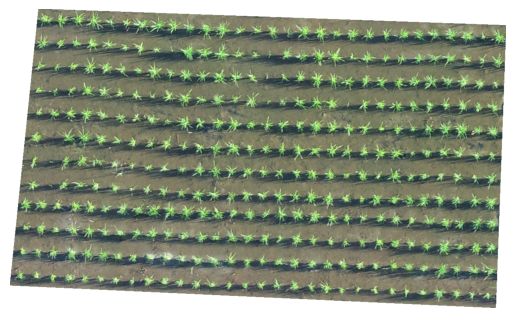

In [44]:
path_img = "/content/test_img (1).tif"
image = cv2.imread(path_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converter BGR para RGB

# Mostrar a imagem
plt.imshow(image)
plt.axis("off")
plt.show()


In [45]:
src = rasterio.open(path_img)

In [46]:
img = src.read()

In [47]:
img.shape

(4, 741, 1230)

In [48]:
img = img.transpose([1,2,0])

In [49]:
img.shape

(741, 1230, 4)

In [50]:
img = img.astype('uint8')

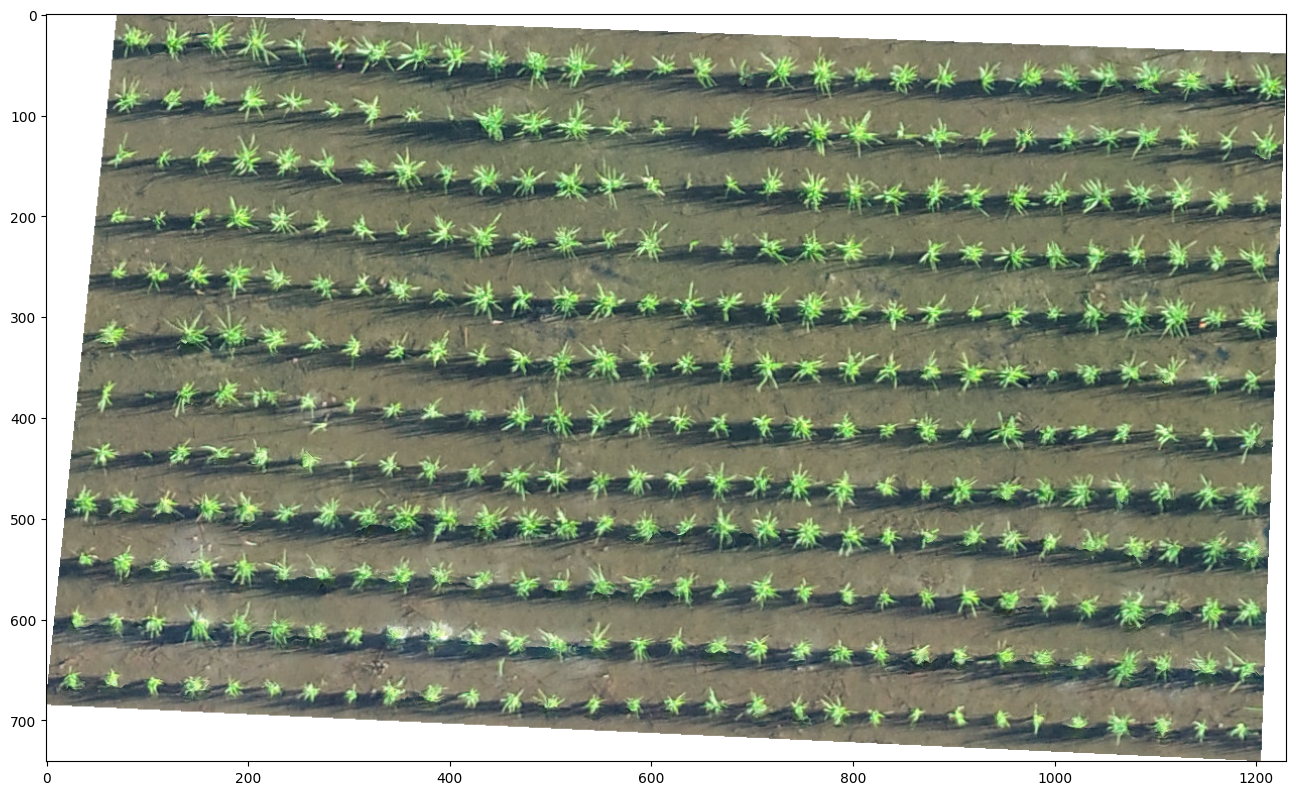

In [51]:
plt.figure(figsize=[16,16])
plt.imshow(img)

In [52]:
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]

(-0.5, 1229.5, 740.5, -0.5)

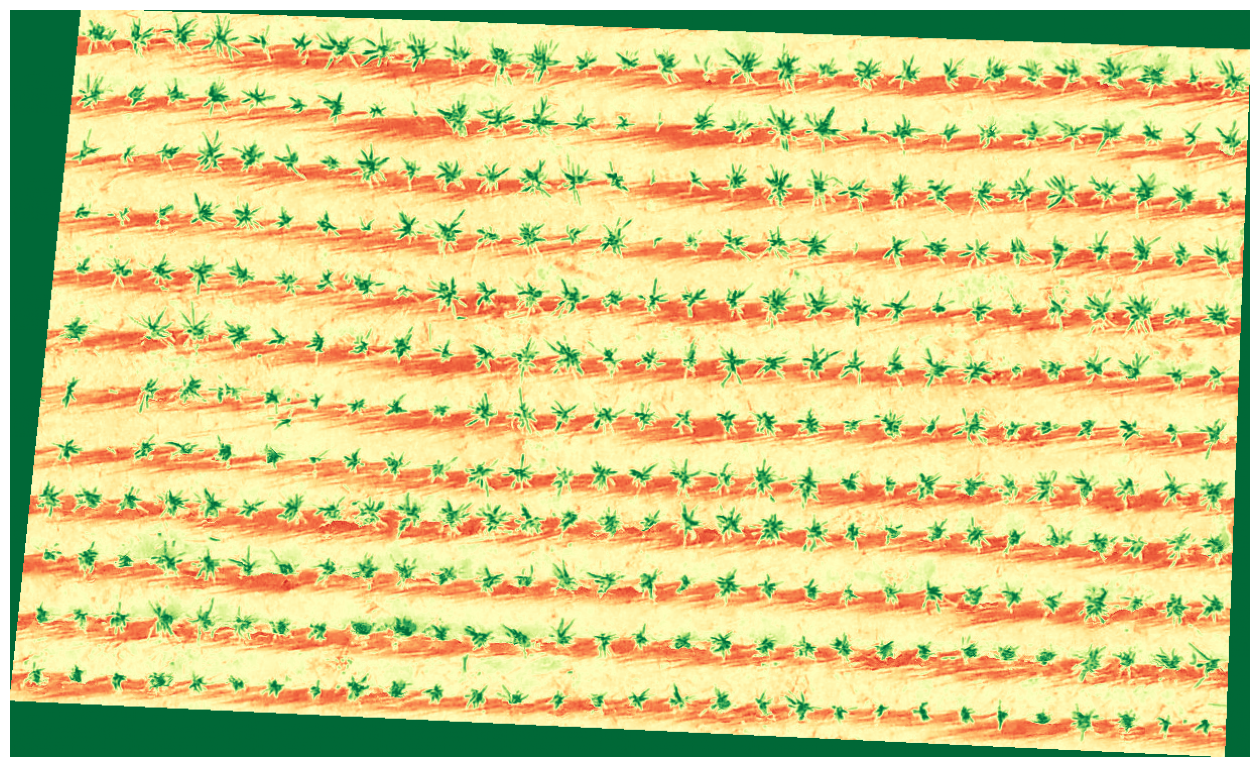

In [53]:
plt.figure(figsize=[16,16])
plt.imshow(G,cmap='RdYlGn')
plt.axis('off')

In [54]:
G = np.where(G == 255,0,G)

In [55]:
from skimage.filters import threshold_multiotsu

In [56]:
thresh = threshold_multiotsu(G)

In [57]:
thresh

array([ 80, 162])

In [58]:
binary = G > thresh[1]

(-0.5, 1229.5, 740.5, -0.5)

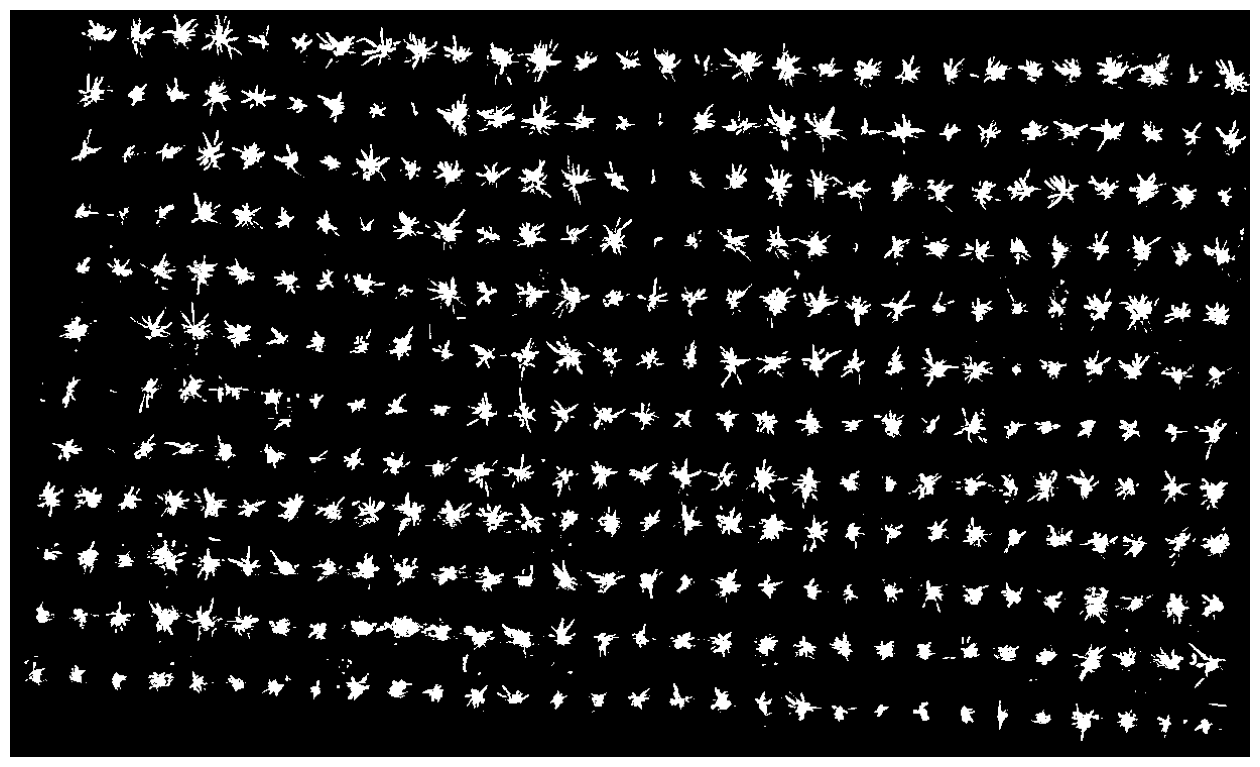

In [59]:
plt.figure(figsize=[16,16])
plt.imshow(binary,cmap=plt.cm.gray)
plt.axis('off')

In [60]:
binary = binary.astype('uint8')

In [61]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

horizontal = cv2.dilate(binary, kernel, iterations = 3)
horizontal = cv2.erode(horizontal, kernel,  iterations = 6)
horizontal = cv2.dilate(horizontal, kernel, iterations = 4)
horizontal = cv2.erode(horizontal, kernel,  iterations = 6)


(-0.5, 1229.5, 740.5, -0.5)

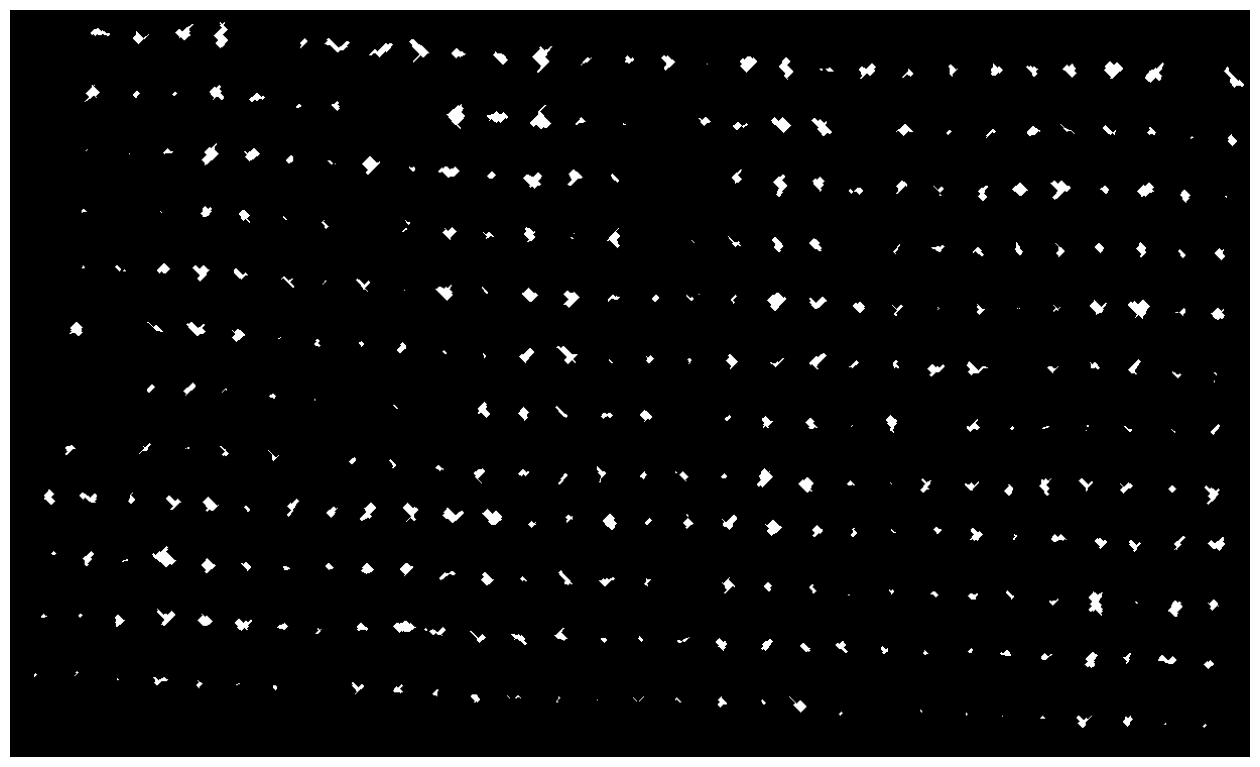

In [62]:
plt.figure(figsize=[16,16])
plt.imshow(horizontal,cmap=plt.cm.gray)
plt.axis('off')

In [63]:
import matplotlib.patches as mpatches

from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

In [64]:
label_image = label(horizontal)

In [65]:
img = img[:,:,0:3]

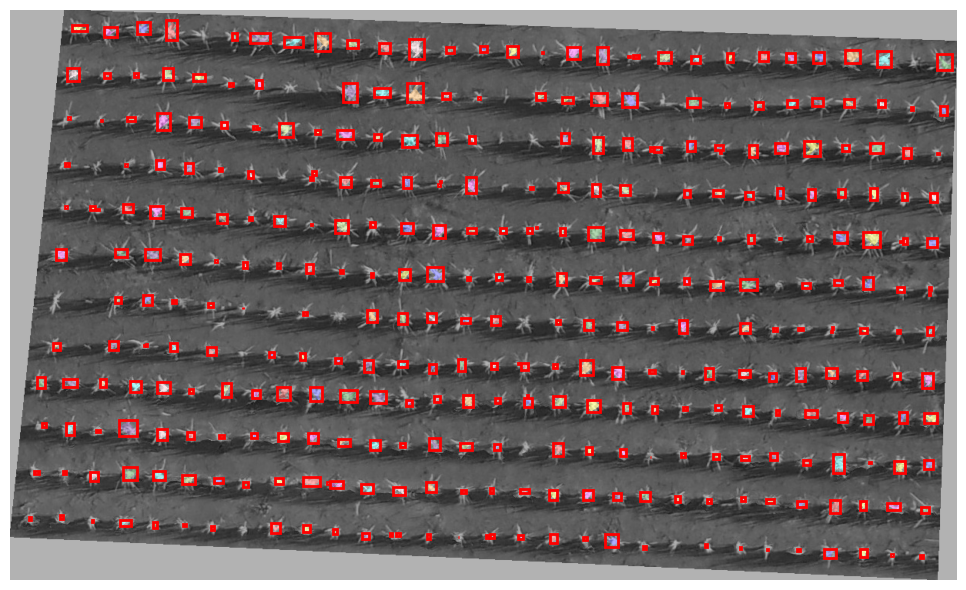

In [66]:
image_label_overlay = label2rgb(label_image, image=img, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    if region.area >= 1:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [67]:
ls_x = []
ls_y = []
for region in regionprops(label_image):
    if region.area >= 1:
      y0, x0 = region.centroid
      xs, ys = rasterio.transform.xy(src.transform, y0, x0)
      ls_x.append(xs)
      ls_y.append(ys)

In [68]:
df_xy = pd.DataFrame([])
df_xy['x'] = ls_x
df_xy['y'] = ls_y

In [69]:
gdf = gpd.GeoDataFrame(df_xy, geometry=gpd.points_from_xy(df_xy['x'], df_xy['y']))

In [70]:
gdf = gdf.set_crs(src.crs)


<Axes: >

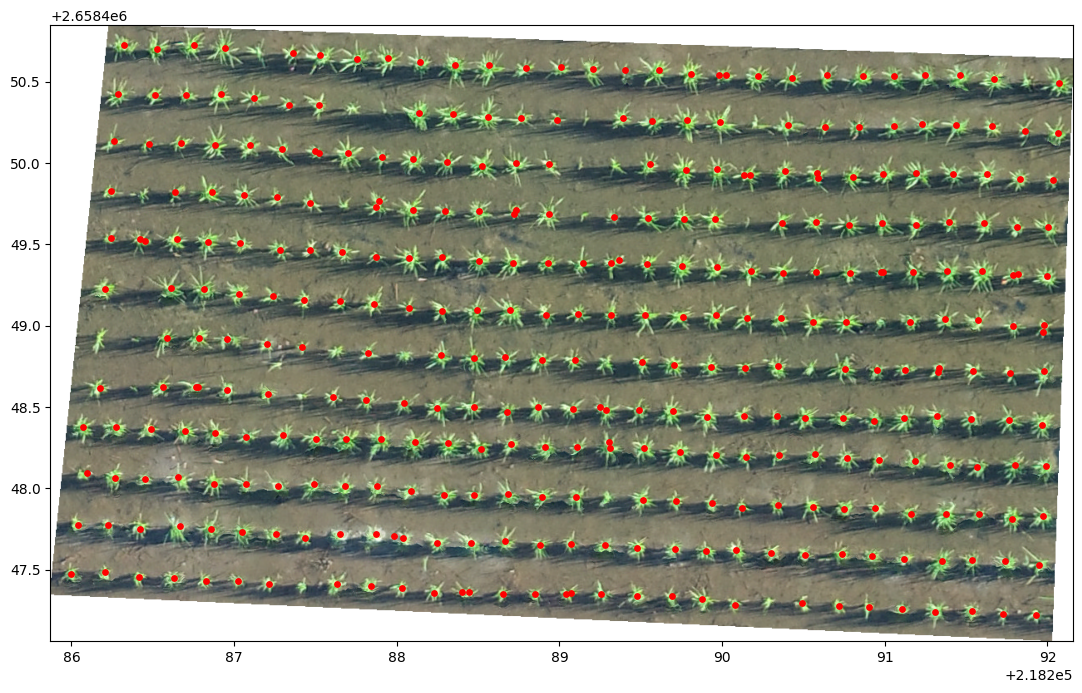

In [77]:
fig, ax = plt.subplots(figsize=(18, 8))
show((src), ax=ax)
gdf.plot(ax=ax,  marker='o', color='red', markersize=15)